In [4]:
import pandas as pd
import random as rd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from sklearn import model_selection
from keras import regularizers
import numpy as np

# Dados

## explorando dados

In [91]:
df_data = pd.read_csv('class_results.csv')

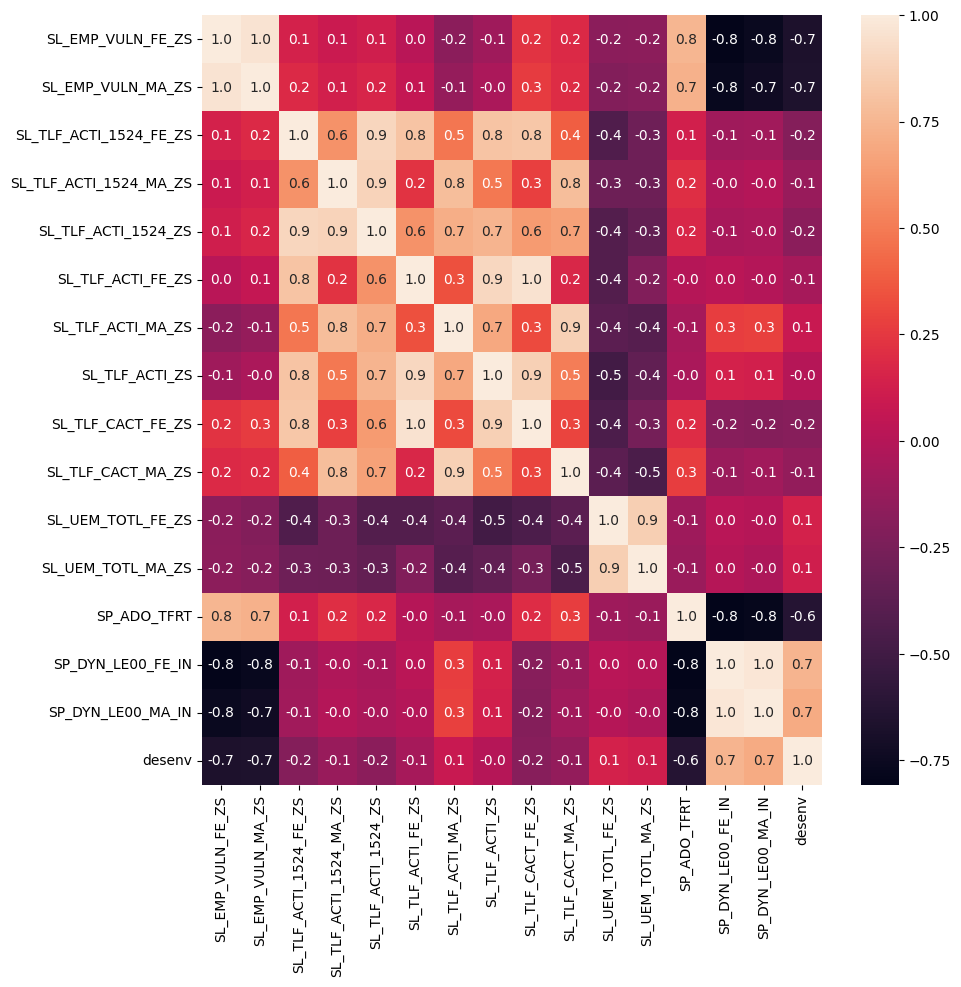

In [92]:
plt.figure(figsize=(10,10))
sns.heatmap(df_data.corr(), annot=True, fmt='.1f')
plt.show()

## Divisão dos dados
Adotaremos a regra de ouro 80, 20:
- 80% de dados para treino
- 20% de dados para teste

In [70]:
class Data():
    def __init__(self, X_data, y_data_co2, y_data_coef, 
                 test_size = 0.15,  
                 random_seed = 42):
        self.X_data = X_data
        self.y_data_co2 = y_data_co2
        self.y_data_coef = y_data_coef
        self.train_size = train_size
        self.test_size = test_size
        self.random_seed = random_seed
        self.size = len(self.X_data)

    def split_data(self):
        ###### SEPARANDO DADOS DE TREINO ######
        indexes_train = rd.sample(range(0, len(self.X_data)), int(self.size*self.train_size)) #separando index de treino
        self.X_train = self.X_data.iloc[indexes_train] #separando dados de treino X
        self.y_train_coef = self.y_data_coef.iloc[indexes_train] #separando dados de treino Y
        self.y_train_co2 = self.y_data_co2.iloc[indexes_train] #separando dados de treino Y

        ###### REMOVENDO DADOS DE TREINO ###### 
        self.X_data = self.X_data.drop(indexes_train) #removendo dados de treino X
        self.X_data = self.X_data.reset_index(drop=True) #resetando index

        self.y_data_coef = self.y_data_coef.drop(indexes_train) #removendo dados de treino Y
        self.y_data_coef = self.y_data_coef.reset_index(drop=True) #resetando index

        self.y_data_co2 = self.y_data_co2.drop(indexes_train) #removendo dados de treino Y
        self.y_data_co2 = self.y_data_co2.reset_index(drop=True) #resetando index

        ##### SEPARANDO DADOS DE TESTE ######
        self.X_test = self.X_data #separando dados de teste X
        self.y_test_coef = self.y_data_coef #separando dados de teste Y
        self.y_test_co2 = self.y_data_co2 #separando dados de teste Y
    
    def get_data_train(self):
        return self.X_train, self.y_train_co2, self.y_train_coef

    def get_data_test(self):
        return self.X_test, self.y_test_co2, self.y_test_coef


In [94]:
y_data_class = df_data['desenv']

X_data = df_data.drop(['desenv'], axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data_class, random_state=42, test_size=0.2)

In [95]:
X_train, X_test, y_train, y_test

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)



Train:  (4141, 15) (4141,)
Test:  (1036, 15) (1036,)


# MODELOS

## Rede neural

## Configurações
### Dimensão VC
No total temos 5007 dados para serem treinados no modelo e a dimensão VC tem a seguinte formula para redes neurais:

$$  n \ge 10 * W $$
> W - peso do modelo

O peso do rede W pode ser representado pela seguinte equação
$$ W = (C+1) * Q_{ce} + (C+1) $$
> C - Numero de colunas no treino  <br>
> Q_ce - Quantide de Camadas Escondidas <br>

Logo, supondo que teremos 1 camada escondida

$$ W =  (15+1) * 1 + (15+1) = 32 $$
$$ n \ge 32*10 = 320 $$

320 dados são suficientes para generalizar

### Regra de ouro
Assim, agora precisamos determinar a quantidade de neuronios que serão utilizados nas camadas ocultas. Para isso podemos utilizar o seguinte artificio matematico:

$$ n \le \frac{|DS| - 10}{10(d + n_e)} $$
> DS - Numero de amostras no dataset de treino
> n_e - Numero de camadas escondidas
> d - numero de _features_

assim,

$$ n \le \frac{3623-10}{10*(15+2)} <=> \frac{3613}{170} \equiv 22 $$

In [96]:
# 1 camada oculta
# 15 valores de entrada
# 22 neuronios na camada oculta

# Criando a arquitetura da rede neural
model = Sequential()

# Rede configurada a partir de informações da dimensão VC e da regra de ouro
model.add(Dense(22, input_dim=15, kernel_initializer='normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

#utilizado a função de ativação tanh para que a saida possa variar entre -1 e 1

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

c:\Users\Xonas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 22)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375 (1.46 KB)

 Trainable params: 375 (1.46 KB)

 Non-trainable params: 0 (0.00 B)

None


In [97]:
BATCH_SIZE = 16
# trainX, train_y, train_y_coef
model_hdi = model.fit(trainX, train_y_coef, epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8101 - loss: 0.4232
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8919 - loss: 0.2568
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9128 - loss: 0.2120
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9055 - loss: 0.2359
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8994 - loss: 0.2116
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9057 - loss: 0.2059
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8865 - loss: 0.2232
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8995 - loss: 0.2074
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9083 - loss: 0.2036
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8938 - loss: 0.2271
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9045 - loss: 0.2418
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━━

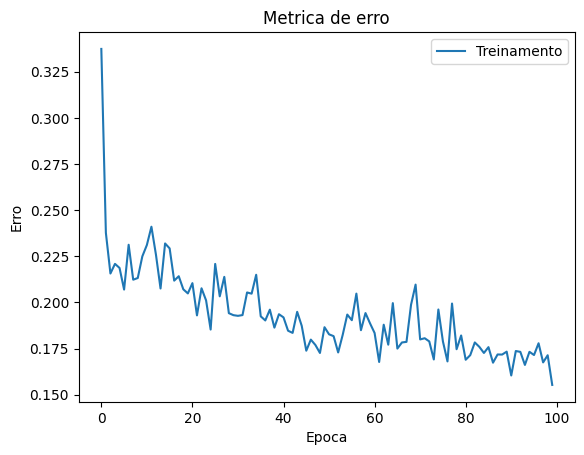

114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [101]:
from sklearn.metrics import accuracy_score

plt.plot(model_hdi.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia usando accuracy_score()
pred = np.round(model.predict(trainX))
acc_train = accuracy_score(train_y_coef, pred)

# Obtendo a acuracia usando evaluate()
E_out, acc_test = model.evaluate(testX, test_y_coef, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - model_hdi.history['loss'][-1]:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

### Validation

In [88]:

history = model.fit(trainX, train_y_coef, validation_data=(validationX, validation_y_coef), epochs=100, batch_size=BATCH_SIZE)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9239 - loss: 0.1707 - val_accuracy: 0.8946 - val_loss: 0.1804
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9208 - loss: 0.1491 - val_accuracy: 0.9242 - val_loss: 0.1955
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9223 - loss: 0.1787 - val_accuracy: 0.9280 - val_loss: 0.1664
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9201 - loss: 0.1748 - val_accuracy: 0.9242 - val_loss: 0.1745
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9298 - loss: 0.1599 - val_accuracy: 0.8817 - val_loss: 0.2007
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9122 - loss: 0.1765 - val_accuracy: 0.9190 - val_loss: 0.1667
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9214 - loss: 0.1655 - val_accuracy: 0.9023 - val_loss: 0.2062
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9193 - loss: 0.1704 - val_accu

KeyError: 'val_loss'

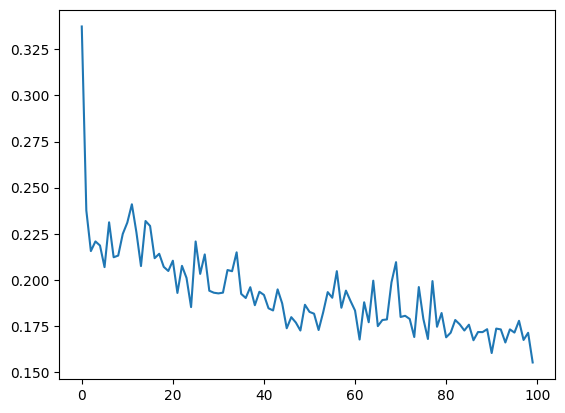

In [100]:
plt.plot(model_hdi.history['loss'])
plt.plot(model_hdi.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred = np.round(model.predict(trainX))
acc_train = accuracy_score(train_y_coef, pred)

pred = np.round(model.predict(validationX))
acc_val = accuracy_score(validation_y_coef, pred)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")
print(f"--> E_val - E_in = {(model_hdi.history['val_loss'][-1] - model_hdi.history['loss'][-1]):.4f}")

In [ ]:
class NeuralNetwork():
    def __init__(self, data):
        self.data = data
        self.X_train, self.y_train_co2, self.y_train_coef = self.data.get_data_train()
        self.X_test, self.y_test_co2, self.y_test_coef = self.data.get_data_test()
        self.X_validation, self.y_validation_co2, self.y_validation_coef = self.data.get_data_validation()
        
    def train(self):
        pass
    
    def predict(self):
        pass
    
    def evaluate(self):
        pass